In [1]:
import numpy as np
import torch
import torch.nn as nn
import pennylane as qml
from pennylane.qnn import TorchLayer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt


In [28]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import sklearn.decomposition
import torch

data = pd.read_csv('DDos.pcap_ISCX.csv')

n_features = 2

data.columns = data.columns.str.strip()

label_col = 'Label'

numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
if label_col in numeric_cols:
    numeric_cols.remove(label_col)

x = data[numeric_cols].to_numpy(dtype=np.float64)
y = data[label_col].astype('category').cat.codes.to_numpy(dtype=np.int64)

x = np.where(np.isinf(x), np.nan, x)             
valid_rows = ~np.isnan(x).any(axis=1)            
x = x[valid_rows]
y = y[valid_rows]

x = StandardScaler().fit_transform(x)
np.random.seed(1967)
perm = np.random.permutation(len(x))
x = x[perm]
y = y[perm]

pca = PCA(n_components=2)
x = pca.fit_transform(x)

x = MinMaxScaler(feature_range=(-1, 1)).fit_transform(x)

trainX, testX, trainy, testy = train_test_split(
    x, y, stratify=y, test_size=0.3, random_state=109
)

print("TrainX shape:", trainX.shape)
print("Trainy shape:", trainy.shape)
print("TestX shape:", testX.shape)
print("Testy shape:", testy.shape)

def one_hot_np(labels, num_classes):
    return np.eye(num_classes)[labels]

num_classes = len(np.unique(y))
trainy_onehot = one_hot_np(trainy, num_classes)
testy_onehot = one_hot_np(testy, num_classes)

trainX_tensor = torch.tensor(trainX, dtype=torch.float32)
testX_tensor = torch.tensor(testX, dtype=torch.float32)
trainy_tensor = torch.tensor(trainy_onehot, dtype=torch.float32)
testy_tensor = torch.tensor(testy_onehot, dtype=torch.float32)


TrainX shape: (157997, 2)
Trainy shape: (157997,)
TestX shape: (67714, 2)
Testy shape: (67714,)


In [30]:
import pennylane as qml
import torch
import torch.nn as nn
from pennylane.qnn import TorchLayer

n_qubits = 2
layers = 1
data_dimension = 2 

dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

weight_shapes = {"weights": (layers, n_qubits, 3)}

quantum_layer = TorchLayer(qnode, weight_shapes)

class HybridModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(data_dimension, n_qubits)
        self.quantum = quantum_layer
        self.fc2 = nn.Linear(n_qubits, data_dimension)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.quantum(x)
        x = self.fc2(x)
        return torch.softmax(x, dim=1)

model = HybridModel()

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()  

In [32]:
%load_ext memory_profiler

In [36]:
%%time
num_epochs = 30
batch_size = 5
history = [] 

model.train()
for epoch in range(num_epochs):
    permutation = torch.randperm(trainX_tensor.size(0))
    epoch_loss = 0.0
    
    for i in range(0, trainX_tensor.size(0), batch_size):
        indices = permutation[i:i + batch_size]
        batch_x = trainX_tensor[indices]
        batch_y = trainy_tensor[indices]  

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = loss_fn(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / (trainX_tensor.size(0) / batch_size)
    history.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}")


Epoch 1/30 - Loss: 0.5729
Epoch 2/30 - Loss: 0.5654
Epoch 3/30 - Loss: 0.5503
Epoch 4/30 - Loss: 0.5474
Epoch 5/30 - Loss: 0.5461
Epoch 6/30 - Loss: 0.5458
Epoch 7/30 - Loss: 0.5456
Epoch 8/30 - Loss: 0.5449
Epoch 9/30 - Loss: 0.5446
Epoch 10/30 - Loss: 0.5441
Epoch 11/30 - Loss: 0.5441
Epoch 12/30 - Loss: 0.5441
Epoch 13/30 - Loss: 0.5437
Epoch 14/30 - Loss: 0.5436
Epoch 15/30 - Loss: 0.5437
Epoch 16/30 - Loss: 0.5433
Epoch 17/30 - Loss: 0.5433
Epoch 18/30 - Loss: 0.5431
Epoch 19/30 - Loss: 0.5427
Epoch 20/30 - Loss: 0.5428
Epoch 21/30 - Loss: 0.5424
Epoch 22/30 - Loss: 0.5429
Epoch 23/30 - Loss: 0.5428
Epoch 24/30 - Loss: 0.5422
Epoch 25/30 - Loss: 0.5424
Epoch 26/30 - Loss: 0.5420
Epoch 27/30 - Loss: 0.5424
Epoch 28/30 - Loss: 0.5421
Epoch 29/30 - Loss: 0.5424
Epoch 30/30 - Loss: 0.5420
CPU times: total: 1d 8h 6min 55s
Wall time: 4h 31min 19s


In [40]:
import torch

model.eval()  
with torch.no_grad():  
    outputs = model(testX_tensor)  
    predy = torch.argmax(outputs, axis=1).cpu().numpy()  

print(predy)

[1 0 0 ... 1 1 0]


In [48]:
realy = testy_tensor.cpu().numpy()  

rounded_labels_real = realy          
rounded_labels_pred = predy          

print(rounded_labels_real)
print(rounded_labels_pred)

[[0. 1.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [1. 0.]]
[1 0 0 ... 1 1 0]


In [68]:
from sklearn.metrics import classification_report, confusion_matrix, recall_score, f1_score, accuracy_score, precision_score

import numpy as np

if len(rounded_labels_real.shape) > 1:
    rounded_labels_real = np.argmax(rounded_labels_real, axis=1)
if len(rounded_labels_pred.shape) > 1:
    rounded_labels_pred = np.argmax(rounded_labels_pred, axis=1)

classification = classification_report(rounded_labels_real, rounded_labels_pred)
confusion = confusion_matrix(rounded_labels_real, rounded_labels_pred)

accuracy = round(accuracy_score(rounded_labels_real, rounded_labels_pred)*100, 5)
recall = round(recall_score(rounded_labels_real, rounded_labels_pred, average='macro')*100, 5)
precision = round(precision_score(rounded_labels_real, rounded_labels_pred, average='weighted')*100, 5)
f1 = round(f1_score(rounded_labels_real, rounded_labels_pred, average='weighted')*100, 5)

print('Classification Report:\n', classification)
print('Confusion Matrix:\n', confusion)
print(f'Accuracy: {accuracy}%')
print(f'Recall: {recall}%')
print(f'Precision: {precision}%')
print(f'F1 Score: {f1}%')
print(f'Error: {100-(accuracy)}%')

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.65      0.79     29306
           1       0.79      1.00      0.88     38408

    accuracy                           0.85     67714
   macro avg       0.89      0.82      0.83     67714
weighted avg       0.88      0.85      0.84     67714

Confusion Matrix:
 [[19134 10172]
 [  142 38266]]
Accuracy: 84.76829%
Recall: 82.46033%
Precision: 87.76976%
F1 Score: 84.07553%
Error: 15.231710000000007%


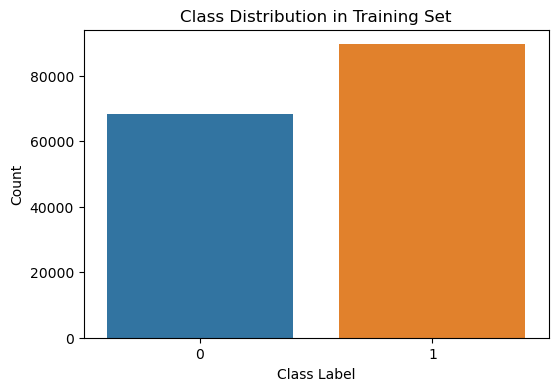

In [70]:
# 1. Class Distribution Plot

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x=trainy)
plt.title('Class Distribution in Training Set')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.show()

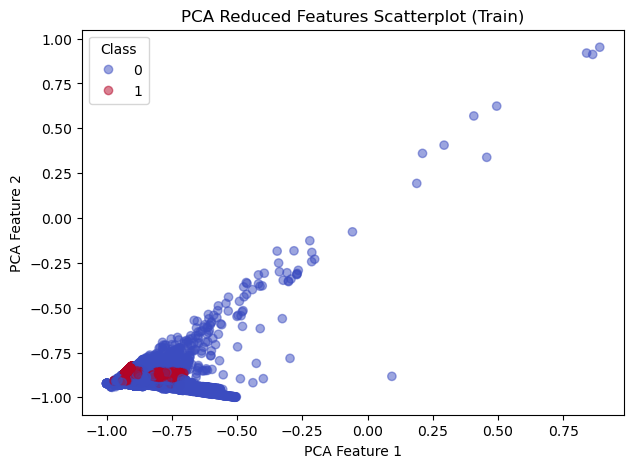

In [72]:
# 2. PCA Feature Scatter Plot

plt.figure(figsize=(7,5))
scatter = plt.scatter(trainX[:, 0], trainX[:, 1], c=trainy, cmap='coolwarm', alpha=0.5)
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.title('PCA Reduced Features Scatterplot (Train)')
plt.legend(*scatter.legend_elements(), title='Class')
plt.show()

C:\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_

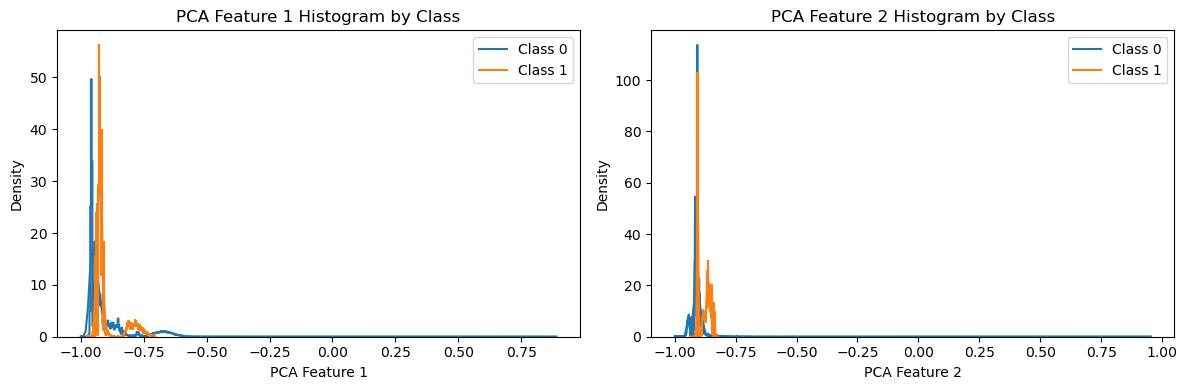

In [74]:
# 3. Histograms of PCA Features Separated by Class

class_labels = np.unique(trainy)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for i in range(2):
    for c in class_labels:
        sns.histplot(trainX[trainy==c, i], label=f'Class {c}', element='step', ax=axes[i], kde=True, stat="density", fill=False)
    axes[i].set_title(f'PCA Feature {i+1} Histogram by Class')
    axes[i].set_xlabel(f'PCA Feature {i+1}')
    axes[i].legend()
plt.tight_layout()
plt.show()

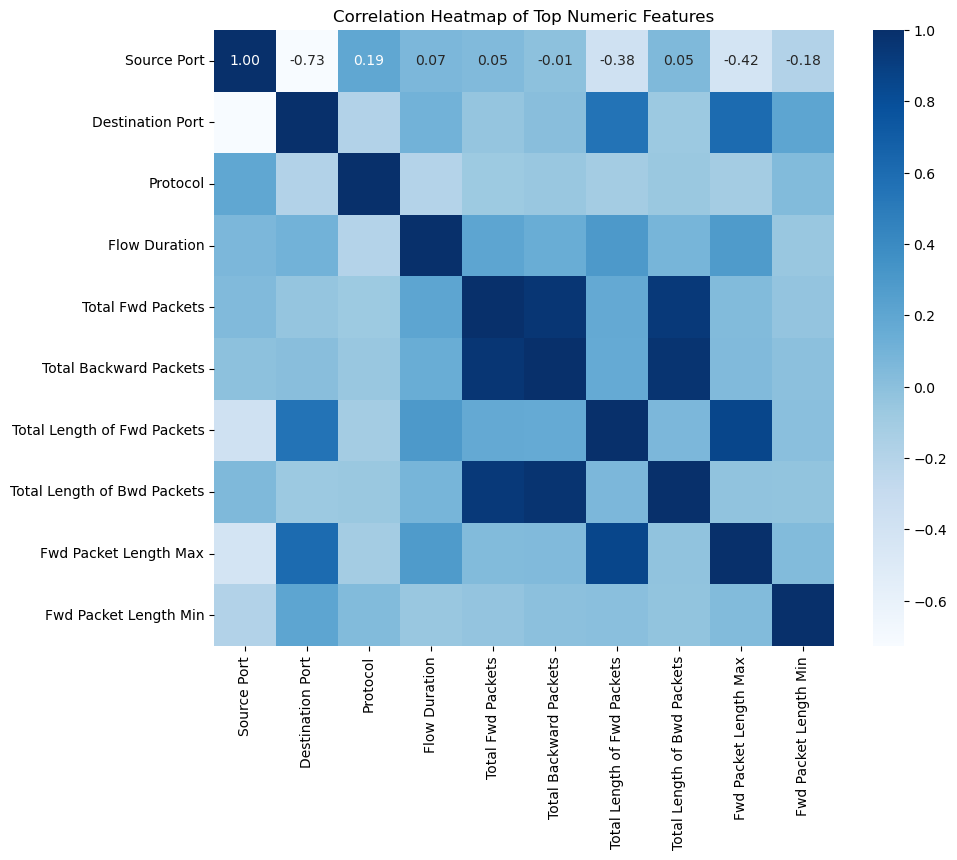

In [76]:
# 4. Correlation Heatmap of Numeric Features

numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
top10_cols = numeric_cols[:10]
plt.figure(figsize=(10, 8))
corr = data[top10_cols].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='Blues')
plt.title('Correlation Heatmap of Top Numeric Features')
plt.show()

C:\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


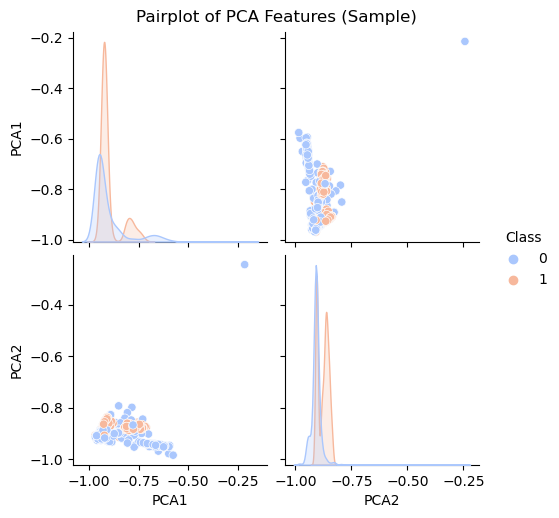

In [78]:
# 5. Pairplot

sample_df = pd.DataFrame(trainX, columns=['PCA1', 'PCA2'])
sample_df['Class'] = trainy
sns.pairplot(sample_df.sample(2000), hue='Class', palette='coolwarm')
plt.suptitle('Pairplot of PCA Features (Sample)', y=1.02)
plt.show()

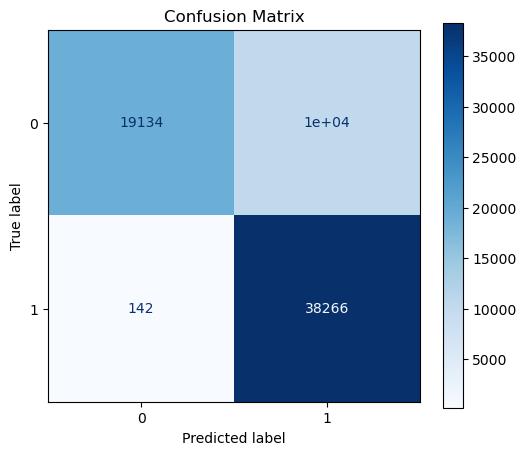

In [88]:
# 6. Confusion Matrix 

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

if len(testy_tensor.shape) > 1 and testy_tensor.shape[1] > 1:
    true_labels = np.argmax(testy_tensor.cpu().numpy(), axis=1)
else:
    true_labels = testy_tensor.cpu().numpy()

pred_labels = predy  

cm = confusion_matrix(true_labels, pred_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(ax=ax, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

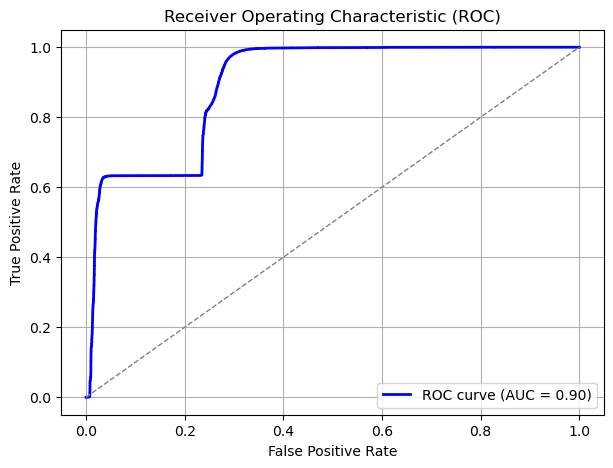

In [86]:
# 7. Plot ROC
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    probas = model(testX_tensor).cpu().numpy()
proba_class1 = probas[:, 1]

fpr, tpr, thresholds = roc_curve(true_labels, proba_class1)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [64]:
import torch

inputs = torch.zeros(2)
weights = torch.zeros(layers, n_qubits, 3)

print(qml.draw(qnode)(inputs, weights))

0: ─╭AngleEmbedding(M0)─╭StronglyEntanglingLayers(M1)─┤  <Z>
1: ─╰AngleEmbedding(M0)─╰StronglyEntanglingLayers(M1)─┤  <Z>

M0 = 
tensor([0., 0.])
M1 = 
tensor([[[0., 0., 0.],
         [0., 0., 0.]]])
